# Power density spectrum

See Fig 1a Buzsaki &  Misuzaki, 2015, NN

**in-vivo**:

* `Horvath`
    * rat
    * rectangular contact of 20 um side, see (2,3)
    * 128ch 
    * 20.0kHz
    * 3688.668s (1h)
    * "Spontaneous activity" (Only anesthetized condition)
    * questions: do we metadata for Horvath? were some of the contacts discarded?
* `Reyes` (Backlogged for now, waiting for Milo's help) 
    * rat
    * neuronexus probe (circular contact of 10 um radius, see (1))
    * 18ch
    * 20.0kHz
    * 4385.500s (1.2h)
    * Serie 1, Exp09, File 2: 
        * "C2 whisker stimulation" (see metadata, Block 0:1000 in "20_selected_files_16by1.xlsx") 
        * "spontaneous activity" (see metadata, Block 1000:4300) 
    
**in-silico**:    

* `npx384`
    * activity simulated for 7 columns (hex_O1) 
    * 10 min-ish
    * 40 KHz
    * 384 contacts     
    * list of channels clearly in the microcircuit:
        - 30-70; 125-165; 221-261; 316-256
* `buccino 2020`
    * answers to question on if we are more realistic than existing models
    * 384 contacts
    * 32 KHz 
    * 10 min (600 secs)
    * activity is simulated on all contacts
    * "spontaneous activity" condition
    * elife
* `npx32` 
    * answers to question on the role of mesoscale lateral connections
    * (10 min-ish)

**Backlogged**:

**in-vivo**:

* `Allen neuropixels`
    * raw recording traces are not available (only low-pass filtered)



TODO:

- What is the unit of amplitude of the Reyes recording trace (mV or microVolt)?
- our is in mV (BlueConfig under lfp report)
- plot by channel and by layer 



### Setup

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import scipy
import spikeinterface.extractors as se 
from matplotlib import pyplot as plt
import matplotlib
import spikeinterface as si
import spikeinterface.preprocessing as spre

# move to PROJECT PATH
# PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/bernstein_2023/"
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/sfn_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

### Setup datasets

In [2]:
# REYES (real)

EXPERIMENT_reyes = "vivo_reyes"
SIMULATION_DATE_reyes = "2015"
data_conf_reyes, _ = get_config(EXPERIMENT_reyes, SIMULATION_DATE_reyes).values()
RAW_RECORDING_PATH_reyes = data_conf_reyes["recording"]["output"]
PREPRO_PATH_REYES = data_conf_reyes["preprocessing"]["output"]["trace_file_path"]
POWER_PATH_REYES = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/realism/power/reyes/"
N_CONTACTS_REYES = 16
SAMP_FREQ_REYES = 20000

# HORVATH (real)

DATA_PATH_horvath = "/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/dataset/horvath/Rat01/Insertion1/Depth2/Rat01_Insertion1_Depth2.nwb"
PREPRO_PATH_horvath = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/preprocessed/horvath/traces"
POWER_PATH_horvath = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/realism/power/horvath/"
N_CONTACTS_horvath = 128
SAMP_FREQ_HORVATH = 20000

# NPX-32CH (1 col)

EXPERIMENT_32 = "silico_neuropixels"
SIMULATION_DATE_32 = "2023_02_19"
data_conf_32, param_conf_32 = get_config(
    EXPERIMENT_32, SIMULATION_DATE_32
).values()  # confs
RAW_RECORDING_PATH_32 = data_conf_32["recording"]["output"]
PREPRO_PATH_32 = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/preprocessed/npx32/traces"
POWER_PATH_32 = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/realism/power/npx32/"
CHANNEL_ID_32 = 0  # set channel
N_CONTACTS_32 = 32
SAMP_FREQ_32 = 10000

# NPX-384 (7 cols)

EXPERIMENT_384 = "silico_neuropixels"
SIMULATION_DATE_384 = "2023_08_17"
data_conf_384, param_conf_384 = get_config(EXPERIMENT_384, SIMULATION_DATE_384).values()
RAW_RECORDING_PATH_384 = data_conf_384["recording"]["output"]
PREPRO_PATH_384 = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/preprocessed/npx384/traces"
POWER_PATH_384 = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/realism/power/npx384/"
N_CONTACTS_384 = 384
SAMP_FREQ_384 = 40000

# Buccino 2020 simulation (silico)

EXPERIMENT_bucci = "buccino_2020"
SIMULATION_DATE_bucci = "2020"
data_conf_bucci, _ = get_config(EXPERIMENT_bucci, SIMULATION_DATE_bucci).values()
RAW_RECORDING_PATH_bucci = data_conf_bucci["recording"]["input"]
PREPRO_PATH_bucci = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/preprocessed/buccino2020/traces"
POWER_PATH_bucci = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/realism/power/buccino2020/"
N_CONTACTS_bucci = 384
SAMP_FREQ_bucci = 32000

2023-09-18 10:10:09,857 - root - utils.py - get_config - INFO - Reading experiment config.


2023-09-18 10:10:09,889 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-18 10:10:09,891 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-18 10:10:10,051 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-18 10:10:10,052 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-18 10:10:10,120 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-09-18 10:10:10,121 - root - utils.py - get_config - INFO - Reading experiment config.
2023-09-18 10:10:10,130 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [3]:
# load raw traces
# in-vivo
raw_reyes = si.load_extractor(RAW_RECORDING_PATH_reyes)
raw_horvath = se.NwbRecordingExtractor(DATA_PATH_horvath)
# in-silico
raw_32 = si.load_extractor(RAW_RECORDING_PATH_32)
raw_384 = si.load_extractor(RAW_RECORDING_PATH_384)
raw_bucci = se.NwbRecordingExtractor(RAW_RECORDING_PATH_bucci)

/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/envs/npx_10m_384ch_unit_classes/lib/python3.9/site-packages/pynwb/ecephys.py:90: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.


In [4]:
# load preprocessed traces
# in-vivo
prepro_reyes = si.load_extractor(PREPRO_PATH_REYES)
prepro_horvath = si.load_extractor(PREPRO_PATH_horvath)
# in-silico
prepro_32 = si.load_extractor(PREPRO_PATH_32)
prepro_384 = si.load_extractor(PREPRO_PATH_384)
prepro_bucci = si.load_extractor(PREPRO_PATH_bucci)

### Power spectrum

#### Compute

In [13]:
# Reyes

## get raw trace power (takes 4 min)
# power_reyes, freq_reyes = power.get_power(raw_reyes, N_CONTACTS_REYES, SAMP_FREQ_REYES)
# prepro_power_reyes, _ = power.get_power(prepro_reyes, N_CONTACTS_REYES, SAMP_FREQ_REYES)

# # save
# if not os.path.isdir(POWER_PATH_REYES):
#     os.makedirs(POWER_PATH_REYES)
# np.save(POWER_PATH_REYES+"power_raw.npy", power_reyes)
# np.save(POWER_PATH_REYES+"freq.npy", freq_reyes)
# np.save(POWER_PATH_REYES+"power_prepro.npy", prepro_power_reyes)

# Horvath

## takes 192 min (3h)
# power_horvath, freq_horvath = get_power(raw_horvath, N_CONTACTS_horvath, SAMP_FREQ_HORVATH)
# prepro_power_horvath, _ = power.get_power(prepro_horvath, N_CONTACTS_horvath, SAMP_FREQ_HORVATH)

## save
# if not os.path.isdir(POWER_PATH_horvath):
#     os.makedirs(POWER_PATH_horvath)
# np.save(POWER_PATH_horvath+"power_raw.npy", power_horvath)
# np.save(POWER_PATH_horvath+"freq.npy", freq_horvath)
# np.save(POWER_PATH_horvath+"power_prepro.npy", prepro_power_horvath)


# npx32

# ## takes 55 secs
# power_32, freq_32 = power.get_power(raw_32, N_CONTACTS_32, SAMP_FREQ_32)
# prepro_power_32, _ = power.get_power(prepro_32, N_CONTACTS_32, SAMP_FREQ_32)

# # save
# if not os.path.isdir(POWER_PATH_32):
#     os.makedirs(POWER_PATH_32)
# np.save(POWER_PATH_32+"power_raw.npy", power_32)
# np.save(POWER_PATH_32+"freq.npy", freq_32)
# np.save(POWER_PATH_32+"power_prepro.npy", prepro_power_32)


# npx384

# # takes 70 min
# power_384, freq_384 = power.get_power(raw_384, N_CONTACTS_384, SAMP_FREQ_384)
# prepro_power_384, _ = power.get_power(prepro_384, N_CONTACTS_384, SAMP_FREQ_384)

# # save
# if not os.path.isdir(POWER_PATH_384):
#     os.makedirs(POWER_PATH_384)
# np.save(POWER_PATH_384+"power_raw.npy", power_384)
# np.save(POWER_PATH_384+"freq.npy", freq_384)
# np.save(POWER_PATH_384+"power_prepro.npy", prepro_power_384)


# buccino

# takes 55 mins
# power_bucci, freq_bucci = power.get_power(raw_bucci, N_CONTACTS_bucci, SAMP_FREQ_bucci)
# prepro_power_bucci, _ = power.get_power(prepro_bucci, N_CONTACTS_bucci, SAMP_FREQ_bucci)

# # save
# if not os.path.isdir(POWER_PATH_bucci):
#     os.makedirs(POWER_PATH_bucci)
# np.save(POWER_PATH_bucci+"power_raw.npy", power_bucci)
# np.save(POWER_PATH_bucci+"freq.npy", freq_bucci)
# np.save(POWER_PATH_bucci+"power_prepro.npy", prepro_power_bucci)

### Load pre-computed

In [5]:
def downsample_power_data(data_path):
    psd = np.load(data_path + "power_raw.npy")
    psd = psd[:, ::100]
    psd_pre = np.load(data_path + "power_prepro.npy")
    psd_pre = psd_pre[:, ::100]
    freq = np.load(data_path + "freq.npy")
    if np.ndim(freq) > 1:
        freq = freq[0, ::100]
    else:
        freq = freq[::100]
    return psd, psd_pre, freq

In [7]:
# # the kernel crashes when we load all at once, so we load, compute the mean and delete
# # takes 20 secs

# # Reyes
# power_reyes = np.load(POWER_PATH_REYES+"power_raw.npy")
# prepro_power_reyes = np.load(POWER_PATH_REYES+"power_prepro.npy")
# freq_reyes = np.load(POWER_PATH_REYES+"freq.npy")

# # horvath
# power_horvath = np.load(POWER_PATH_horvath+"power_raw.npy")
# prepro_power_horvath = np.load(POWER_PATH_horvath+"power_prepro.npy")
# freq_horvath = np.load(POWER_PATH_horvath+"freq.npy")

# # # npx32
# # power_32 = np.load(POWER_PATH_32+"power_raw.npy")
# # prepro_power_32 = np.load(POWER_PATH_32+"power_prepro.npy")
# # freq_32 = np.load(POWER_PATH_32+"freq.npy")

# # # bucci
# # power_bucci = np.load(POWER_PATH_bucci+"power_raw.npy")
# # prepro_power_bucci = np.load(POWER_PATH_bucci+"power_prepro.npy")
# # freq_bucci = np.load(POWER_PATH_bucci+"freq.npy")

# # # npx384
# # power_384 = np.load(POWER_PATH_384+"power_raw.npy")
# # prepro_power_384 = np.load(POWER_PATH_384+"power_prepro.npy")
# # freq_384 = np.load(POWER_PATH_384+"freq.npy")

### Plot

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)

Plot raw power density spectra on x and y log scales

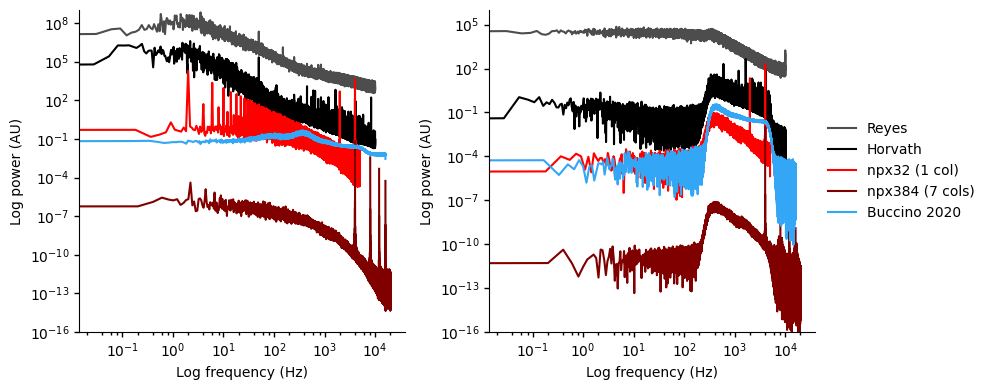

In [14]:
# takes 2 mins
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# reyes
psd, _, freq = downsample_power_data(POWER_PATH_REYES)
axes[0].plot(freq, np.mean(psd, axis=0), color=[0.3, 0.3, 0.3])
del psd
del freq

# horvath
psd, _, freq = downsample_power_data(POWER_PATH_horvath)
axes[0].plot(freq, np.mean(psd, axis=0), color=[0, 0, 0])
del psd
del freq

# 32
psd, _, freq = downsample_power_data(POWER_PATH_32)
axes[0].plot(freq, np.mean(psd, axis=0), color=[1, 0, 0])
del psd
del freq

# 384
psd, _, freq = downsample_power_data(POWER_PATH_384)
axes[0].plot(freq, np.mean(psd, axis=0), color=[0.5, 0, 0])
del psd
del freq

# 384
psd, _, freq = downsample_power_data(POWER_PATH_bucci)
axes[0].plot(freq, np.mean(psd, axis=0), color=[0.2, 0.65, 0.96])
del psd
del freq

axes[0].set_xlabel("Log frequency (Hz)")
axes[0].set_ylabel("Log power (AU)")
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].set_ylim([1e-16, 1e9])

# show minor ticks
axes[0].tick_params(which="both", width=1)
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12)
axes[0].xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# preprocessed
# reyes
_, psd_pre, freq = downsample_power_data(POWER_PATH_REYES)
axes[1].plot(freq, np.mean(psd_pre, axis=0), color=[0.3, 0.3, 0.3], label="Reyes")
del psd_pre
del freq

# horvath
_, psd_pre, freq = downsample_power_data(POWER_PATH_horvath)
axes[1].plot(freq, np.mean(psd_pre, axis=0), color=[0, 0, 0], label="Horvath")
del psd_pre
del freq

# 32
_, psd_pre, freq = downsample_power_data(POWER_PATH_32)
axes[1].plot(freq, np.mean(psd_pre, axis=0), color=[1, 0, 0], label="npx32 (1 col)")
del psd_pre
del freq

# 384
_, psd_pre, freq = downsample_power_data(POWER_PATH_384)
axes[1].plot(freq, np.mean(psd_pre, axis=0), color=[0.5, 0, 0], label="npx384 (7 cols)")
del psd_pre
del freq

# 384
_, psd_pre, freq = downsample_power_data(POWER_PATH_bucci)
axes[1].plot(
    freq, np.mean(psd_pre, axis=0), color=[0.2, 0.65, 0.96], label="Buccino 2020"
)
del psd_pre
del freq

axes[1].set_xlabel("Log frequency (Hz)")
axes[1].set_ylabel("Log power (AU)")
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].spines[["right", "top"]].set_visible(False)
axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
axes[1].set_ylim([1e-16, 1e6])

# show minor ticks
axes[1].tick_params(which="both", width=1)
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12)
axes[1].xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()

Plot normalize to start near 1 (divide each mean psd by the mean amplitude over the first 3 frequencies)

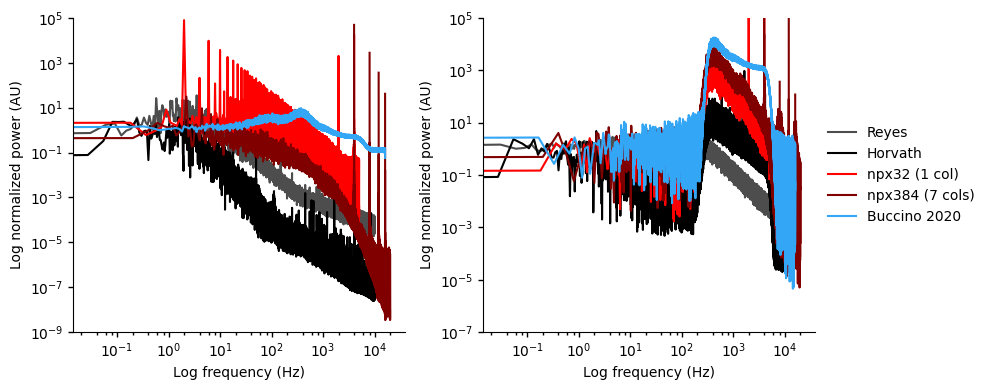

In [43]:
# takes 2 mins

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# pick first the first frequencies
# amplitude to divide by
NORM_WIND = np.arange(0, 5, 1)

# reyes
psd, _, freq = downsample_power_data(POWER_PATH_REYES)
psd_mean = np.mean(psd, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[0].plot(freq, norm_psd, color=[0.3, 0.3, 0.3])
del psd
del freq

# horvath
psd, _, freq = downsample_power_data(POWER_PATH_horvath)
psd_mean = np.mean(psd, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[0].plot(freq, norm_psd, color=[0, 0, 0])
del psd
del freq

# 32
psd, _, freq = downsample_power_data(POWER_PATH_32)
psd_mean = np.mean(psd, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[0].plot(freq, norm_psd, color=[1, 0, 0])
del psd
del freq

# 384
psd, _, freq = downsample_power_data(POWER_PATH_384)
psd_mean = np.mean(psd, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[0].plot(freq, norm_psd, color=[0.5, 0, 0])
del psd
del freq

# 384
psd, _, freq = downsample_power_data(POWER_PATH_bucci)
psd_mean = np.mean(psd, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[0].plot(freq, norm_psd, color=[0.2, 0.65, 0.96])
del psd
del freq

axes[0].set_xlabel("Log frequency (Hz)")
axes[0].set_ylabel("Log normalized power (AU)")
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].spines[["right", "top"]].set_visible(False)
axes[0].set_ylim([1e-9, 1e5])

# show minor ticks
axes[0].tick_params(which="both", width=1)
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12)
axes[0].xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# preprocessed
# reyes
_, psd_pre, freq = downsample_power_data(POWER_PATH_REYES)
psd_mean = np.mean(psd_pre, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[1].plot(freq, norm_psd, color=[0.3, 0.3, 0.3], label="Reyes")
del psd_pre
del freq

# horvath
_, psd_pre, freq = downsample_power_data(POWER_PATH_horvath)
psd_mean = np.mean(psd_pre, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[1].plot(freq, norm_psd, color=[0, 0, 0], label="Horvath")
del psd_pre
del freq

# 32
_, psd_pre, freq = downsample_power_data(POWER_PATH_32)
psd_mean = np.mean(psd_pre, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[1].plot(freq, norm_psd, color=[1, 0, 0], label="npx32 (1 col)")
del psd_pre
del freq

# 384
_, psd_pre, freq = downsample_power_data(POWER_PATH_384)
psd_mean = np.mean(psd_pre, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[1].plot(freq, norm_psd, color=[0.5, 0, 0], label="npx384 (7 cols)")
del psd_pre
del freq

# 384
_, psd_pre, freq = downsample_power_data(POWER_PATH_bucci)
psd_mean = np.mean(psd_pre, axis=0)
norm_psd = psd_mean / np.mean(psd_mean[NORM_WIND])
axes[1].plot(freq, norm_psd, color=[0.2, 0.65, 0.96], label="Buccino 2020")
del psd_pre
del freq

axes[1].set_xlabel("Log frequency (Hz)")
axes[1].set_ylabel("Log normalized power (AU)")
axes[1].set_yscale("log")
axes[1].set_xscale("log")
axes[1].spines[["right", "top"]].set_visible(False)
axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
axes[1].set_ylim([1e-7, 1e5])

# show minor ticks
axes[1].tick_params(which="both", width=1)
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12)
axes[1].xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout()

# save figures
plt.savefig("figures/2_realism/3_power/pdf/powers.pdf")
plt.savefig("figures/2_realism/3_power/svg/powers.svg")